# PRE-PROCESSING  Unique MidCounts

# Purpose

To Prepare Necessary Data files of Unique Counts required for the modeling

# Steps


1) New Code to Import data from metadata files

2) Import function automatically parses rep,batch and other metadata

2) Adding Mean and Control Mean along with the effect to Data Frame

# Outputs

1) ../processed/UC.tsv 

2) ../processed/UC_meanadded.tsv

In [3]:
# NOTEBOOK

In [9]:
#Required Packages 

In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(require(reshape)))

In [2]:
# Data Import and construct a large data frame containing all of the experiments in this batch.

In [3]:
## A Function That can Reurn dataframe from metadata file of filelocations,strain,condition,rep
##Input : Metadata file
## ouput :: Dataframe

import_tndata <- function(file){

##Creating a empty list to concatenate dataframes produced in the for loop
tnfiles<- list()
suppressWarnings(
# For every row in the metadata file
for (g in 1:nrow(file)){
    # capture file location
    floc=as.character(file$Filename[g])
    # Check if file is a dataframe of merged replicates(n>1) or just one replicate 
    # if file has merged replicates, perform below operation
    if ((file$Type[g]=="MERGED")& (file$nrep[g]>1)){
    
         tnfiles[[g]]<- read_tsv(floc, 
            col_names=c('ref', 'start', 'stop', 'tag', paste("rep", seq(1,file$nrep[g]), sep="")),
            col_types=paste("ciic",strrep("i", file$nrep[g]), sep=""), na='.') %>%  # read from csv with headers
        dplyr::select(-ref, -start, -stop) %>%  # drop not-needed columns
        gather(rep, tncnt, -tag) %>%
        mutate(rep = parse_number(rep)) %>%
        mutate(locus_tag = str_match(tag, "locus_tag=([a-zA-Z0-9_]+)")[,2])%>%add_column(strain=file$Strain[g],condition=file$Condition[g],batch=file$Batch[g],time=file$Time[g])%>%  # add background and condition columns
        dplyr::select(strain, condition, locus_tag,rep,batch,time,tncnt)%>%mutate(tncnt=replace_na(tncnt, 0))%>%drop_na()

    
}
    # if file has only one replicate per line, perform below operation
   suppressMessages( if (file$Type[g]=="REP"){
    
         tnfiles[[g]]<- read_tsv(floc, na='.')  %>%  # drop not-needed columns
        mutate(locus_tag = locus_tag)%>%mutate(tncnt = value)%>%
        add_column(strain=file$Strain[g],condition=file$Condition[g],batch=file$Batch[g],rep=file$nrep[g],slevel=file$Slevel[g],time=file$Time[g])%>%  # add background and condition columns
        dplyr::select(locus_tag,strain, condition,slevel,rep,batch,tncnt,time)%>%mutate(tncnt=replace_na(tncnt, 0))%>%drop_na()%>%filter(batch!=".")

    
    })
    
    
})
tn <- do.call(rbind, tnfiles)
    return(tn)
    
    }

In [4]:
# Input Sample Metadata of Unique counts to the import function

In [5]:
metafile <- read.table("../../data//interim/p1p2p3_metadata_unique_mid.txt",header=T)
tn<- import_tndata(metafile)
tn <- tn%>%filter(time!=0)
tn <- tn%>%group_by(strain,condition,slevel,rep,batch,time)%>%mutate(Librarysize=sum(tncnt))%>%ungroup()
write_tsv(tn, '../../data/processed/UC_mid_production1_2_3_4_5.tsv')

In [6]:
# Writing UC data to TC.tsv 

In [7]:
#Adding Mean and Control Mean along with effect

In [8]:
suppressWarnings(suppressMessages(library(rnbtn)))
fct_rel <- list(strain =c('WT','DLON','DCLPA','DKJ','DCLPB'), condition=c('CONTROL','HS','OS','CAN'), slevel=c('none','HIGH','MEDIUM','LOW'))

tnmean <- rnbtn_mean_agg(df = tn,locus_tag = 'locus_tag',tncnt = 'tncnt',fctrel = fct_rel)
tnmean%>%dplyr::filter(locus_tag=="CCNA_03138")

ERROR: Error in library(rnbtn): there is no package called 'rnbtn'


In [9]:
write_tsv(tnmean, '../../data/processed/UC_mid_production1_2_3_4_5_mean.tsv')

In [25]:
#library size

In [9]:
ldf<- tn%>%group_by(strain,condition,slevel,rep,batch,time)%>%summarise(N=sum(tncnt))
ldf$batch=as.factor(ldf$batch)
ldf$rep=as.factor(ldf$rep)

`summarise()` has grouped output by 'strain', 'condition', 'slevel', 'rep', 'batch'. You can override using
the `.groups` argument.


In [12]:
mean(ldf$N)

[1] 89739.28

In [10]:
ldf%>%group_by(strain) %>%
  summarise_at(vars(N), list(name = mean))

strain,name
<chr>,<dbl>
DCLPA,53129.54
DCLPB,30556.00
DKJ,37059.25
DLON,146410.36
WT,186481.55


In [13]:
ldf%>%group_by(condition) %>%
  summarise_at(vars(N), list(name = mean))

condition,name
<chr>,<dbl>
CAN,91008.35
CONTROL,100604.50
HS,90436.60
OS,84013.42


In [14]:
ldf%>%group_by(strain,condition) %>%
  summarise_at(vars(N), list(name = mean))

strain,condition,name
<chr>,<chr>,<dbl>
DCLPA,CAN,53051.36
DCLPA,CONTROL,49058.75
DCLPA,HS,47961.08
DCLPA,OS,59726.58
DCLPB,CAN,30588.07
DCLPB,CONTROL,29412.00
DCLPB,HS,30835.42
DCLPB,OS,30617.83
DKJ,CAN,34009.17


In [15]:
ldf%>%group_by(batch) %>%4,016,942
  summarise_at(vars(N), list(name = mean))

batch,name
<fct>,<dbl>
1,138705.27
2,115869.86
3,50190.66
4,87492.50
5,31657.80


`summarise()` has grouped output by 'strain', 'condition', 'slevel', 'rep', 'batch'. You can override using the `.groups` argument.



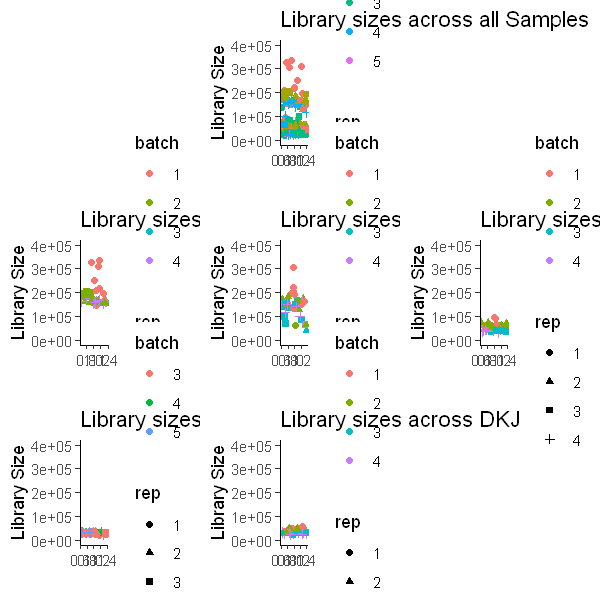

In [16]:
ldf<- tn%>%group_by(strain,condition,slevel,rep,batch,time)%>%summarise(N=sum(tncnt))
ldf$batch=as.factor(ldf$batch)
ldf$rep=as.factor(ldf$rep)

options(repr.plot.width=5, repr.plot.height=5)
p1<- ggplot()+geom_jitter(data=ldf, aes(x=1, y=N, color=batch,shape=rep))+theme_bw()+ylab("Library Size")+xlab("")+theme(axis.line = element_line(colour = "black"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank())+ggtitle("Library sizes across all Samples")+ylim(c(0,400000))
#WT
ldf1<- ldf%>%filter(strain=="WT")
p2<- ggplot()+geom_jitter(data=ldf1, aes(x=1, y=N, color=batch,shape=rep))+theme_bw()+ylab("Library Size")+xlab("")+theme(axis.line = element_line(colour = "black"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank())+ggtitle("Library sizes across WT")+ylim(c(0,400000))
#dlon
ldf2<- ldf%>%filter(strain=="DLON")
p3<- ggplot()+geom_jitter(data=ldf2, aes(x=1, y=N, color=batch,shape=rep))+theme_bw()+ylab("Library Size")+xlab("")+theme(axis.line = element_line(colour = "black"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank())+ggtitle("Library sizes across DLON")+ylim(c(0,400000))
#dclpA
ldf3<- ldf%>%filter(strain=="DCLPA")
p4<- ggplot()+geom_jitter(data=ldf3, aes(x=1, y=N, color=batch,shape=rep))+theme_bw()+ylab("Library Size")+xlab("")+theme(axis.line = element_line(colour = "black"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank())+ggtitle("Library sizes across DCLPA")+ylim(c(0,400000))
#dclpB
ldf4<- ldf%>%filter(strain=="DCLPB")
p5<- ggplot()+geom_jitter(data=ldf4, aes(x=1, y=N, color=batch,shape=rep))+theme_bw()+ylab("Library Size")+xlab("")+theme(axis.line = element_line(colour = "black"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank())+ggtitle("Library sizes across DCLPB")+ylim(c(0,400000))
#DKJ
ldf5<- ldf%>%filter(strain=="DKJ")
p6<- ggplot()+geom_jitter(data=ldf5, aes(x=1, y=N, color=batch,shape=rep))+theme_bw()+ylab("Library Size")+xlab("")+theme(axis.line = element_line(colour = "black"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank())+ggtitle("Library sizes across DKJ")+ylim(c(0,400000))
library(gridExtra)
p0 <- ggplot() + theme_void()
p <- grid.arrange(p0,p1,p0,p2,p3,p4,p5,p6 ,ncol=3,heights = c(0.5,0.5,0.5))
ggsave(filename = "../../reports/production1_2_3/Library_size_UC.pdf", device = "pdf",  plot = p, width = 15, height = 15, dpi = 300, units = "in")
